# Libraries

In [1]:
import pandas as pd
import numpy as np
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
from gensim.test.utils import get_tmpfile
import mplcursors
%matplotlib widget

[nltk_data] Downloading package punkt to /home/a2211506/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [115]:
!wget "https://aclanthology.org/anthology+abstracts.bib.gz" -O anthology_abstracts.bib.gz

--2022-09-06 11:18:50--  https://aclanthology.org/anthology+abstracts.bib.gz
aclanthology.org (aclanthology.org) をDNSに問いあわせています... 174.138.37.75
aclanthology.org (aclanthology.org)|174.138.37.75|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 17305580 (17M) [application/x-gzip]
`anthology_abstracts.bib.gz' に保存中

anthology_abstracts 100%[===================>]  16.50M  8.63MB/s 時間 1.9s       

2022-09-06 11:18:53 (8.63 MB/s) - `anthology_abstracts.bib.gz' へ保存完了 [17305580/17305580]



In [4]:
!gzip -d anthology_abstracts.bib.gz

gzip: anthology_abstracts.bib already exists; do you wish to overwrite (y or n)? ^C


# Preprocessing
## BibTexの形式について
### ENTRYTYPEについて
`anthology_abstracts`には`ENTRYTYPE`の取りうる値に`proceedings`と`inproceedings`の2つが存在する。  
- `proceedings`: 議事録(アブストラクトが存在しない)  
- `inproceedings`: 論文(アブストラクトが存在する)  
したがって、アブストラクトを得るためには、`ENTRYTYPE`が`inproceedings`のものを取得する。  
### Abstractについて
- 現在から2017年まではAbstractが存在する

In [7]:
!head anthology_abstracts.bib -n 464902  > anthology_abstracts_2017_2022.bib

In [8]:
with open("anthology_abstracts_2017_2022.bib") as f:
    s = f.read()

In [9]:
s = s.replace("apr", '"apr"').replace("may", '"may"').replace("jun", '"jun"').replace("jul", '"jul"').replace("aug", '"aug"').replace("sep", '"sep"').replace("oct", '"oct"').replace("nov", '"nov"').replace("dec", '"dec"').replace("jan", '"jan"').replace("feb", '"feb"').replace("mar", '"mar"')
with open("anthology_abstracts_2017_2022_modified.bib", mode='w') as f:
    f.write(s)

In [10]:
# https://bibtexparser.readthedocs.io/en/master/
import bibtexparser
with open('anthology_abstracts_2017_2022_modified.bib') as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

In [12]:
bib_database.entries[0]

{'url': 'https://aclanthology.org/2022.wordplay-1.0',
 'publisher': 'Association for Computational Linguistics',
 'address': 'Seattle, United States',
 'year': '2022',
 'month': 'jul',
 'editor': "C{\\^o}t{\\'e}, Marc-Alexandre  and\nYuan, Xingdi  and\nAmmanabrolu, Prithviraj",
 'title': 'Proceedings of the 3rd Wordplay: When Language Meets Games Workshop (Wordplay 2022)',
 'ENTRYTYPE': 'proceedings',
 'ID': 'wordplay-2022-wordplay'}

In [13]:
with open("anthology_abstracts_2017_2022_modified.bib.pkl","wb") as f:
    pickle.dump(bib_database, f)

In [14]:
!chmod 555 anthology_abstracts_2017_2022_modified.bib.pkl

In [2]:
with open("anthology_abstracts_2017_2022_modified.bib.pkl", "rb") as f:
    anthology2017_2022 = pickle.load(f)

In [3]:
anthology2017_2022_pd = (pd.DataFrame(anthology2017_2022.entries))
anthology2017_2022_pd = anthology2017_2022_pd[(anthology2017_2022_pd["ENTRYTYPE"]  == "inproceedings") & (anthology2017_2022_pd["publisher"] == "Association for Computational Linguistics")] 
anthology2017_2022_pd.iloc[0:3]

,url,publisher,address,year,month,editor,title,ENTRYTYPE,ID,abstract,pages,doi,booktitle,author,language,volume,journal,number,isbn
1,https://aclanthology.org/2022.wordplay-1.1,Association for Computational Linguistics,"Seattle, United States",2022,jul,NaN,A Systematic Survey of Text Worlds as Embodied...,inproceedings,"""jan""sen-2022-systematic",Text Worlds are virtual environments for embod...,1--15,10.18653/v1/2022.wordplay-1.1,Proceedings of the 3rd Wordplay: When Language...,"Jansen, Peter",NaN,NaN,NaN,NaN,NaN
2,https://aclanthology.org/2022.wordplay-1.2,Association for Computational Linguistics,"Seattle, United States",2022,jul,NaN,A Minimal Computational Improviser Based on Or...,inproceedings,montfort-bartlett-fernandez-2022-minimal,A prototype system for playing a minimal impro...,16--24,10.18653/v1/2022.wordplay-1.2,Proceedings of the 3rd Wordplay: When Language...,"Montfort, Nick and\nBartlett Fernandez, Sebas...",NaN,NaN,NaN,NaN,NaN
4,https://aclanthology.org/2022.woah-1.2,Association for Computational Linguistics,"Seattle, Washington (Hybrid)",2022,jul,NaN,Towards Automatic Generation of Messages Count...,inproceedings,ashida-komachi-2022-towards,"With the widespread use of social media, onlin...",11--23,10.18653/v1/2022.woah-1.2,Proceedings of the Sixth Workshop on Online Ab...,"Ashida, Mana and\nKomachi, Mamoru",NaN,NaN,NaN,NaN,NaN


In [4]:
docs = anthology2017_2022_pd.iloc[:]["abstract"]

In [5]:
docs_tokenized = [(nltk.word_tokenize(str(doc))) for doc in (docs)]

In [6]:
docs_tokenized[0]

['Text',
 'Worlds',
 'are',
 'virtual',
 'environments',
 'for',
 'embodied',
 'agents',
 'that',
 ',',
 'unlike',
 '2D',
 'or',
 '3D',
 'environments',
 ',',
 'are',
 'rendered',
 'exclusively',
 'using',
 'textual',
 'descriptions',
 '.',
 'These',
 'environments',
 'offer',
 'an',
 'alternative',
 'to',
 'higher-fidelity',
 '3D',
 'environments',
 'due',
 'to',
 'their',
 'low',
 'barrier',
 'to',
 'entry',
 ',',
 'providing',
 'the',
 'ability',
 'to',
 'study',
 'semantics',
 ',',
 'compositional',
 'inference',
 ',',
 'and',
 'other',
 'high-level',
 'tasks',
 'with',
 'rich',
 'action',
 'spaces',
 'while',
 'controlling',
 'for',
 'perceptual',
 'input',
 '.',
 'This',
 'systematic',
 'survey',
 'outlines',
 'recent',
 'developments',
 'in',
 'tooling',
 ',',
 'environments',
 ',',
 'and',
 'agent',
 'modeling',
 'for',
 'Text',
 'Worlds',
 ',',
 'while',
 'examining',
 'recent',
 'trends',
 'in',
 'knowledge',
 'graphs',
 ',',
 'common',
 'sense',
 'reasoning',
 ',',
 'transfe

# Documents to Vectors

In [7]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs_tokenized)]
model = Doc2Vec(documents, vector_size=128, window=2, min_count=1, workers=-1)

In [ ]:
# model.save("anthology2022.model")

In [ ]:
!chmod 555 anthology2022.model

In [9]:
model = Doc2Vec.load("anthology2022.model")

In [10]:
model.dv[0]

array([-4.0865745e-03, -4.6711937e-03, -7.7193398e-03,  6.6819098e-03,
        2.7860273e-03,  2.0549260e-04, -7.7192411e-03, -4.0364452e-03,
       -7.5921584e-03,  1.5709214e-03,  2.2111796e-03,  3.6277771e-03,
       -3.3572465e-03, -2.4575833e-03, -2.4053026e-03, -6.8139974e-03,
        1.6972516e-03,  7.2075166e-03, -7.4233338e-03, -2.7016308e-03,
       -2.9452424e-03,  2.0370167e-03, -4.4465289e-03,  2.0474065e-03,
        4.5332201e-03, -6.3334852e-03, -6.5076500e-03, -7.7770855e-03,
        3.8539413e-03, -7.1268026e-03,  4.5640338e-03,  5.3127054e-03,
       -5.0831251e-03, -3.5311580e-03, -9.8036043e-04,  1.2861881e-03,
       -1.1572950e-03, -6.6738613e-03, -2.8145425e-03,  1.3528317e-03,
       -1.6069692e-03, -5.6484714e-03,  3.2692179e-03, -6.6987034e-03,
        2.1183882e-03, -3.6044698e-03,  5.0424039e-04, -1.6073026e-03,
        4.2290837e-03, -6.2520094e-03, -1.6561337e-03, -7.4855983e-05,
       -5.1865447e-03, -5.0985664e-03, -1.5101247e-03,  6.8777148e-03,
      

In [11]:

data = [[(i)] + list(model.dv[i]) for i in range(len(documents))]
column_names = ["type"]+["x_"+str(dim) for dim in range(model.vector_size)]
out = pd.DataFrame(data, columns=column_names)
# out = out.sort_values(["type"])
out.to_csv("anthology2022.csv", index=None)
out.insert(1, 'year', anthology2017_2022_pd['year'].values)
out.insert(2, 'title', anthology2017_2022_pd['title'].values)
out

,type,year,title,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127
0,0,2022,A Systematic Survey of Text Worlds as Embodied...,-0.004087,-0.004671,-0.007719,0.006682,0.002786,0.000205,-0.007719,...,0.002859,0.006326,0.006951,0.004880,-0.004874,0.006770,-0.007366,0.000554,-0.005174,-0.000625
1,1,2022,A Minimal Computational Improviser Based on Or...,0.002063,-0.006011,0.003093,0.001115,-0.000420,0.004858,-0.003420,...,-0.001561,0.004814,-0.005440,-0.006790,-0.007565,-0.006261,-0.005024,-0.001805,-0.001834,0.004910
2,2,2022,Towards Automatic Generation of Messages Count...,0.003528,0.004057,0.002054,0.001589,0.003578,0.006848,0.004164,...,0.006334,-0.001039,0.007193,-0.006093,0.001928,0.006982,-0.007615,-0.000961,-0.006725,0.005595
3,3,2022,{G}rease{V}ision: Rewriting the Rules of the I...,-0.001633,0.004768,-0.003725,0.002522,-0.003051,-0.007043,-0.002335,...,-0.000792,0.005549,0.004894,0.003550,-0.000893,0.000306,-0.006690,0.000036,-0.005288,0.006117
4,4,2022,Improving Generalization of Hate Speech Detect...,0.005179,-0.004625,-0.001097,0.002516,-0.003448,0.006718,0.003742,...,0.002558,-0.000880,-0.002310,0.004100,0.003550,-0.005085,0.001933,0.006109,0.006555,0.002714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,10090,2017,Structured Learning for Temporal Relation Extr...,0.007119,0.005514,-0.001409,-0.003843,-0.006543,-0.002984,0.003406,...,-0.001235,0.002746,0.000915,0.003988,-0.001617,-0.005585,0.004073,0.001602,-0.007613,-0.005564
10091,10091,2017,Distant Supervision for Relation Extraction be...,-0.004482,-0.006832,0.000109,-0.002097,-0.007678,-0.004195,-0.006564,...,0.007100,0.005360,0.007599,-0.004290,-0.001984,0.002885,-0.004737,-0.003437,-0.007574,0.000346
10092,10092,2017,Noise Mitigation for Neural Entity Typing and ...,-0.005207,0.000364,-0.007028,0.004428,0.005774,0.001917,-0.004543,...,0.006720,0.001794,-0.000410,-0.005081,0.002714,-0.000244,-0.004499,-0.006341,-0.006382,0.003864
10093,10093,2017,Analyzing Semantic Change in {J}apanese Loanwords,0.003391,-0.002609,0.007664,-0.003310,-0.002223,0.001418,-0.007033,...,-0.000050,0.006502,-0.000379,0.005621,0.007496,0.006451,-0.003851,0.000442,-0.002821,-0.005945


In [12]:
# sampling 
SAMPLING_RATE = 0.025
sampled_out = out.sample(n=(int(len(out)*SAMPLING_RATE)), random_state=1)
title_list = out['title'].values
X = sampled_out.iloc[:, 3:]
pca = PCA(n_components=2)
pca.fit(X)
x_pcx = pca.transform(X)
x_pcx.shape

(252, 2)

In [13]:
# color_map = {'2022': 'b', 
#         '2021': 'g',
#         '2020': 'r',
#         '2019': 'c',
#         '2018': 'm',
#         '2017': 'y'} 
color_map = {'2022': 2022, 
        '2021': 2021,
        '2020': 2020,
        '2019': 2019,
        '2018': 2018,
        '2017': 2017} 
year_list = list(sampled_out['year'].values)
mapped_year_list = [color_map.get(element, element)  for element in year_list]

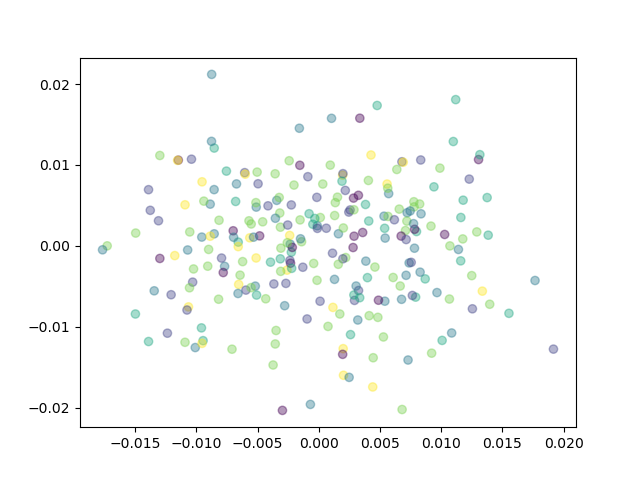

In [14]:
fig, ax = plt.subplots()
ax.scatter(x_pcx[:, 0], x_pcx[:, 1], c=mapped_year_list,  alpha=0.4)
plt.show()

## Visualization(Mouse hover)

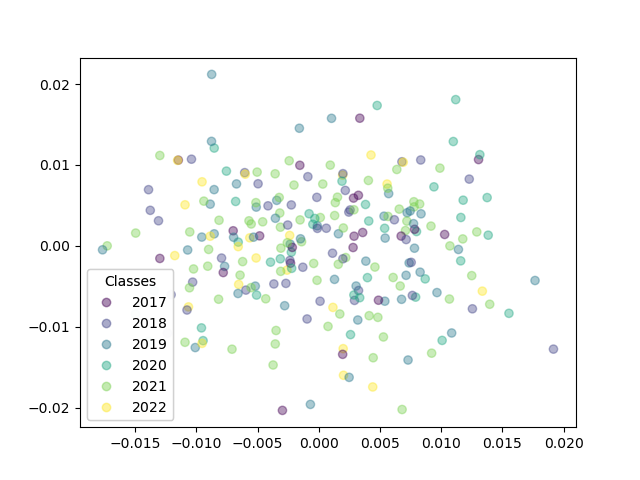

In [16]:
fig, ax = plt.subplots()
sc = ax.scatter(x_pcx[:, 0], x_pcx[:, 1], c=mapped_year_list,  alpha=0.4)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*sc.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

cursor = mplcursors.cursor(sc, hover=True)
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=title_list[sel.Selection.index])
plt.show()

In [ ]:
# 主成分
print(f"PCA componments shape:\n{pca.components_.shape}")

PCA componments shape:
(2, 128)


Text(0.5, 0, 'Feature')

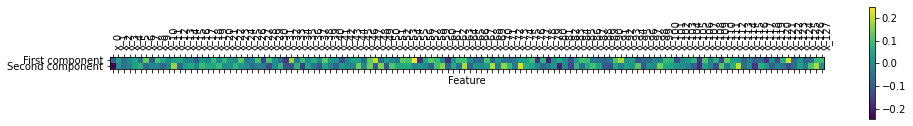

In [ ]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(column_names[1:])),
           column_names[1:], rotation=90, ha='left', )
plt.xlabel("Feature")

# t-SNE

In [48]:
from sklearn.manifold import TSNE

X = sampled_out.iloc[:, 3:]
tsne = TSNE(random_state=42) # , init='pca', learning_rate="auto"
x_tsne = tsne.fit_transform(X)
x_tsne.shape

/home/a2211506/anaconda3/envs/InuiLab/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/a2211506/anaconda3/envs/InuiLab/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(252, 2)

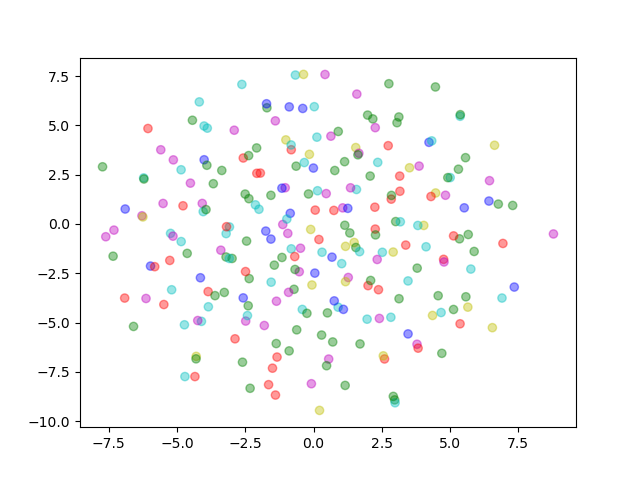

In [49]:
fig, ax = plt.subplots()
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=mapped_year_list,  alpha=0.4)
plt.show()

# 今後検討しても良いこと
- 2022 と2017(みやすさ)
- サンプリングする(みやすさ)
- ニュース記事とACL